In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Documents/Study/Robotics/optimal_control_julia/lec_2/Project.toml`


In [2]:
using LinearAlgebra
using PyPlot
using ForwardDiff

In [3]:
function pendulum_dynamics(x)
    l = 1.0
    g = 9.81
    
    θ = x[1]
    θ̇ = x[2]
    
    θ̈ = -(g/l)*sin(θ)
    
    return [θ̇; θ̈]
end

pendulum_dynamics (generic function with 1 method)

In [4]:
function pendulum_forward_euler(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= x_hist[:,k] + h*fun(x_hist[:,k])
        @show x_hist[:,k+1]
    end
    
    return x_hist, t
end

pendulum_forward_euler (generic function with 1 method)

x_hist[:, k + 1] = [0.1, -0.09793658173053843]
x_hist[:, k + 1] = [0.09020634182694616, -0.19587316346107686]
x_hist[:, k + 1] = [0.07061902548083847, -0.2842456204249306]
x_hist[:, k + 1] = [0.0421944634383454, -0.35346531728551706]
x_hist[:, k + 1] = [0.006847931709793698, -0.3948458045856677]
x_hist[:, k + 1] = [-0.032636648748773076, -0.4015635730886598]
x_hist[:, k + 1] = [-0.07279300605763905, -0.3695527041063783]
x_hist[:, k + 1] = [-0.1097482764682769, -0.29820581321354245]
x_hist[:, k + 1] = [-0.13956885778963113, -0.1907587518003433]
x_hist[:, k + 1] = [-0.15864473296966547, -0.05428578140333837]
x_hist[:, k + 1] = [-0.16407331110999931, 0.10069270073984135]
x_hist[:, k + 1] = [-0.15400404103601517, 0.2609274334087077]
x_hist[:, k + 1] = [-0.1279112976951444, 0.41140891327951845]
x_hist[:, k + 1] = [-0.08677040636719255, 0.5365480041254455]
x_hist[:, k + 1] = [-0.033115605954648, 0.6215629978756293]
x_hist[:, k + 1] = [0.02904069383291493, 0.6540434699751838]
x_hist[:, k + 1]

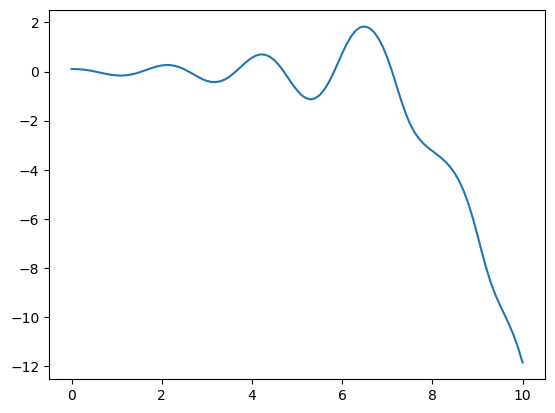

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15d5fa740>

In [6]:
x0 = [.1; 0]
x_hist1, t_hist1 = pendulum_forward_euler(pendulum_dynamics, x0, 50, .01)
plot(t_hist1, x_hist1[1,:])

In [15]:
function pendulum_euler_Ad(x0, h)
    g = 9.81
    Ad = [1 h; -g*h*cos(x0[1]) 1]
end

pendulum_euler_Ad (generic function with 1 method)

In [16]:
eigvals(pendulum_euler_Ad(0, 0.001))

2-element Vector{ComplexF64}:
 1.0 - 0.0031320919526731652im
 1.0 + 0.0031320919526731652im

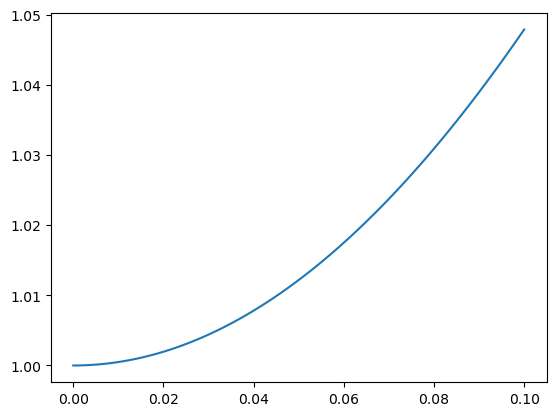

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x10aef4820>

In [17]:
eignorm = zeros(100)
h = LinRange(0,0.1,100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(pendulum_euler_Ad([0;0], h[k])))...)
end
plot(h,eignorm)

In [10]:
function fd_pendulum_rk4(xk, h)
    f1 = pendulum_dynamics(xk)
    f2 = pendulum_dynamics(xk + 0.5*h*f1)
    f3 = pendulum_dynamics(xk + 0.5*h*f2)
    f4 = pendulum_dynamics(xk + h*f3)
    return xk + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

fd_pendulum_rk4 (generic function with 1 method)

In [11]:
function pendulum_rk4(fun, x0, Tf, h)    
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= fd_pendulum_rk4(x_hist[:,k], h)
    end
    
    return x_hist, t
end

pendulum_rk4 (generic function with 1 method)

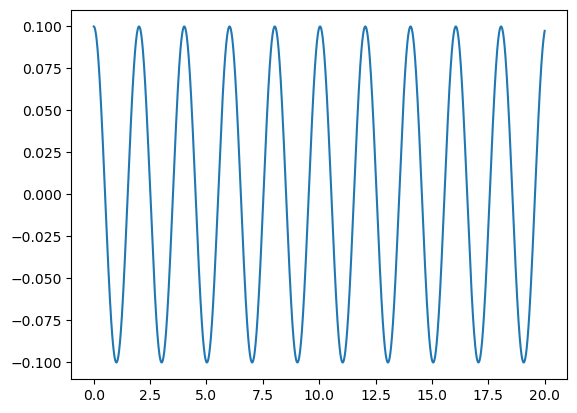

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15d6946d0>

In [12]:
x0 = [.1; 0]
x_hist2, t_hist2 = pendulum_rk4(pendulum_dynamics, x0, 20, 0.01)
plot(t_hist2, x_hist2[1,:])

In [23]:
using ForwardDiff
Ad = ForwardDiff.jacobian(x -> fd_pendulum_rk4(x, 0.1), [0; 0])
norm.(eigvals(Ad))

2-element Vector{Float64}:
 0.999993524288704
 0.999993524288704

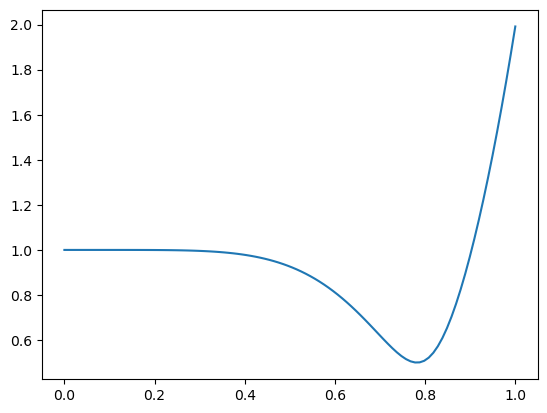

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x10b0f8400>

In [24]:
eignorm = zeros(100)
h = LinRange(0,1,100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(ForwardDiff.jacobian(x -> fd_pendulum_rk4(x, h[k]), [0; 0])))...)
end
plot(h,eignorm)

In [5]:
function pendulum_backward_euler(fun, x0, Tf, dt)
    t = Array(range(0,Tf,step=dt))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        e = 1
        x_hist[:,k+1] = x_hist[:,k]
        while e > 1e-8
            xn = x_hist[:,k] + dt.*fun(x_hist[:,k+1])
            e = norm(xn - x_hist[:,k+1])
            x_hist[:,k+1] .= xn
        end
    end
    
    return x_hist, t
end

pendulum_backward_euler (generic function with 1 method)

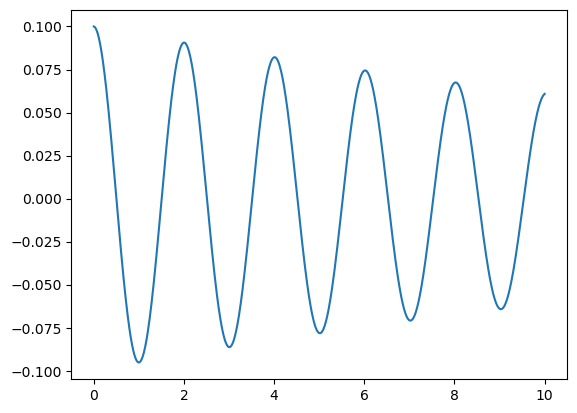

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x15b9b80a0>

In [7]:
x0 = [.1; 0]
x_hist3, t_hist3 = pendulum_backward_euler(pendulum_dynamics, x0, 10, 0.01)
plot(t_hist3, x_hist3[1,:])